# Evalutation statistique : régression logistique
## Library

In [9]:
import numpy as np
import pandas as pd
from sas7bdat import SAS7BDAT

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

## DataFrame

In [10]:
file_path = 'individus_ct2013.sas7bdat'
with SAS7BDAT(file_path) as reader:
    df = reader.to_data_frame()
df.info()

[individus_ct2013.sas7bdat] column count mismatch
[individus_ct2013.sas7bdat] [individus_ct2013.sas7bdat] column count mismatch


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33673 entries, 0 to 33672
Columns: 541 entries, C1C to revmenscc_drap
dtypes: float64(76), object(465)
memory usage: 139.0+ MB


## Périmètre de l'étude
* On s'intérresse uniquement aux individus vivant en couple dans le même logement. 

In [11]:
df = df.query('COUPLE == "1"')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24024 entries, 2 to 33672
Columns: 541 entries, C1C to revmenscc_drap
dtypes: float64(76), object(465)
memory usage: 99.3+ MB


## Variable dépendante binaire
* Créeation d'une variable binaire pour indiquer si la femme est le principal apporteur de ressources
    - [PRACT = 1] == (Oui, l'enquêté est le principal apporteur)
    - [SEXE = 2] == (Femme)

In [12]:

# Créer la nouvelle colonne 'femme_principal_apporteur' avec des valeurs 1 ou 0
df['FPA'] = df.apply(lambda row: 1 if (row['PRACT'] == '1' and row['SEXE'] == '2') else 0, axis=1)

# Compter le nombre de lignes où 'femme_principal_apporteur' est égal à 1
nb_FPA = df['FPA'].sum()

print("Nombre de lignes où 'femme_principal_apporteur' est égal à", nb_FPA)

Nombre de lignes où 'femme_principal_apporteur' est égal à 5080


## Préparation des données *(valeurs manquantes et traitement)*
* Sélectionner des variables indépendantes

#### Critères de Sélection des Variables
Pour choisir les variables explicatives, vous pouvez considérer plusieurs critères :

Corrélations avec la variable dépendante : Utilisez des tests statistiques ou des tableaux de contingence pour identifier les variables qui montrent des relations significatives avec PRACT.

Éviter la multicollinéarité : Assurez-vous que les variables explicatives ne sont pas fortement corrélées entre elles, car cela peut biaiser les estimations de votre modèle.

#### Méthodes de Sélection des Variables
Analyse exploratoire : Utilisez des techniques d'analyse exploratoire des données telles que des graphiques et des tableaux récapitulatifs pour comprendre la distribution des variables et leurs relations avec la variable dépendante.

Tests statistiques : Effectuez des tests statistiques appropriés pour évaluer l'association entre chaque variable explicative potentielle et la variable dépendante. Par exemple, pour les variables continues, vous pouvez utiliser des tests tels que le test t de Student, et pour les variables catégorielles, des tests comme le test du χ² peuvent être appropriés.

Analyse de corrélation : Utilisez des mesures de corrélation (par exemple, le coefficient de corrélation de Pearson) pour évaluer les relations linéaires entre les variables continues.

Analyse de variance : Pour les variables catégorielles, examinez les différences de moyennes entre les groupes définis par chaque catégorie par rapport à la variable dépendante.

In [13]:
variables_dict = {
    'target': ['FPA'],
    'etat_civil_familial': ['ANAIS', 'ETAMATRI', 'PACS', 'MER1E', 'PER1E'],
    'situation_travail': ['SITUA', 'CJSITUA', 'RABS', 'STATUTEXT', 'SSECH', 'METIER',],
    'revenus_conditions_vie': ['REVMENUC', 'AIDFAM'], 
    'caracteristiques_logement_familial': ['TYPOLOG', 'TYPMEN15', 'NBENFM3', 'NBENF3A17', 'NBENF18P', 'NPERS', 'NACTIFS']
}

# Accès aux listes individuelles
print("* Etat civil et familial:", variables_dict['etat_civil_familial'])
print("* Situation travail:", variables_dict['situation_travail'])
print("* Revenus et conditions de vie:", variables_dict['revenus_conditions_vie'])
print("* Caractéristiques du logement et familial:", variables_dict['caracteristiques_logement_familial'])

* Etat civil et familial: ['ANAIS', 'ETAMATRI', 'PACS', 'MER1E', 'PER1E']
* Situation travail: ['SITUA', 'CJSITUA', 'RABS', 'STATUTEXT', 'SSECH', 'METIER']
* Revenus et conditions de vie: ['REVMENUC', 'AIDFAM']
* Caractéristiques du logement et familial: ['TYPOLOG', 'TYPMEN15', 'NBENFM3', 'NBENF3A17', 'NBENF18P', 'NPERS', 'NACTIFS']


## Exploration des données
* Exploration des données (utiliser des tableaux de contingence pour explorer les relations entre la variable dépendante et les variables explicatives)
* Visualisations (histogrammes, diagramme en baree etc..) pour comprendre la distribution

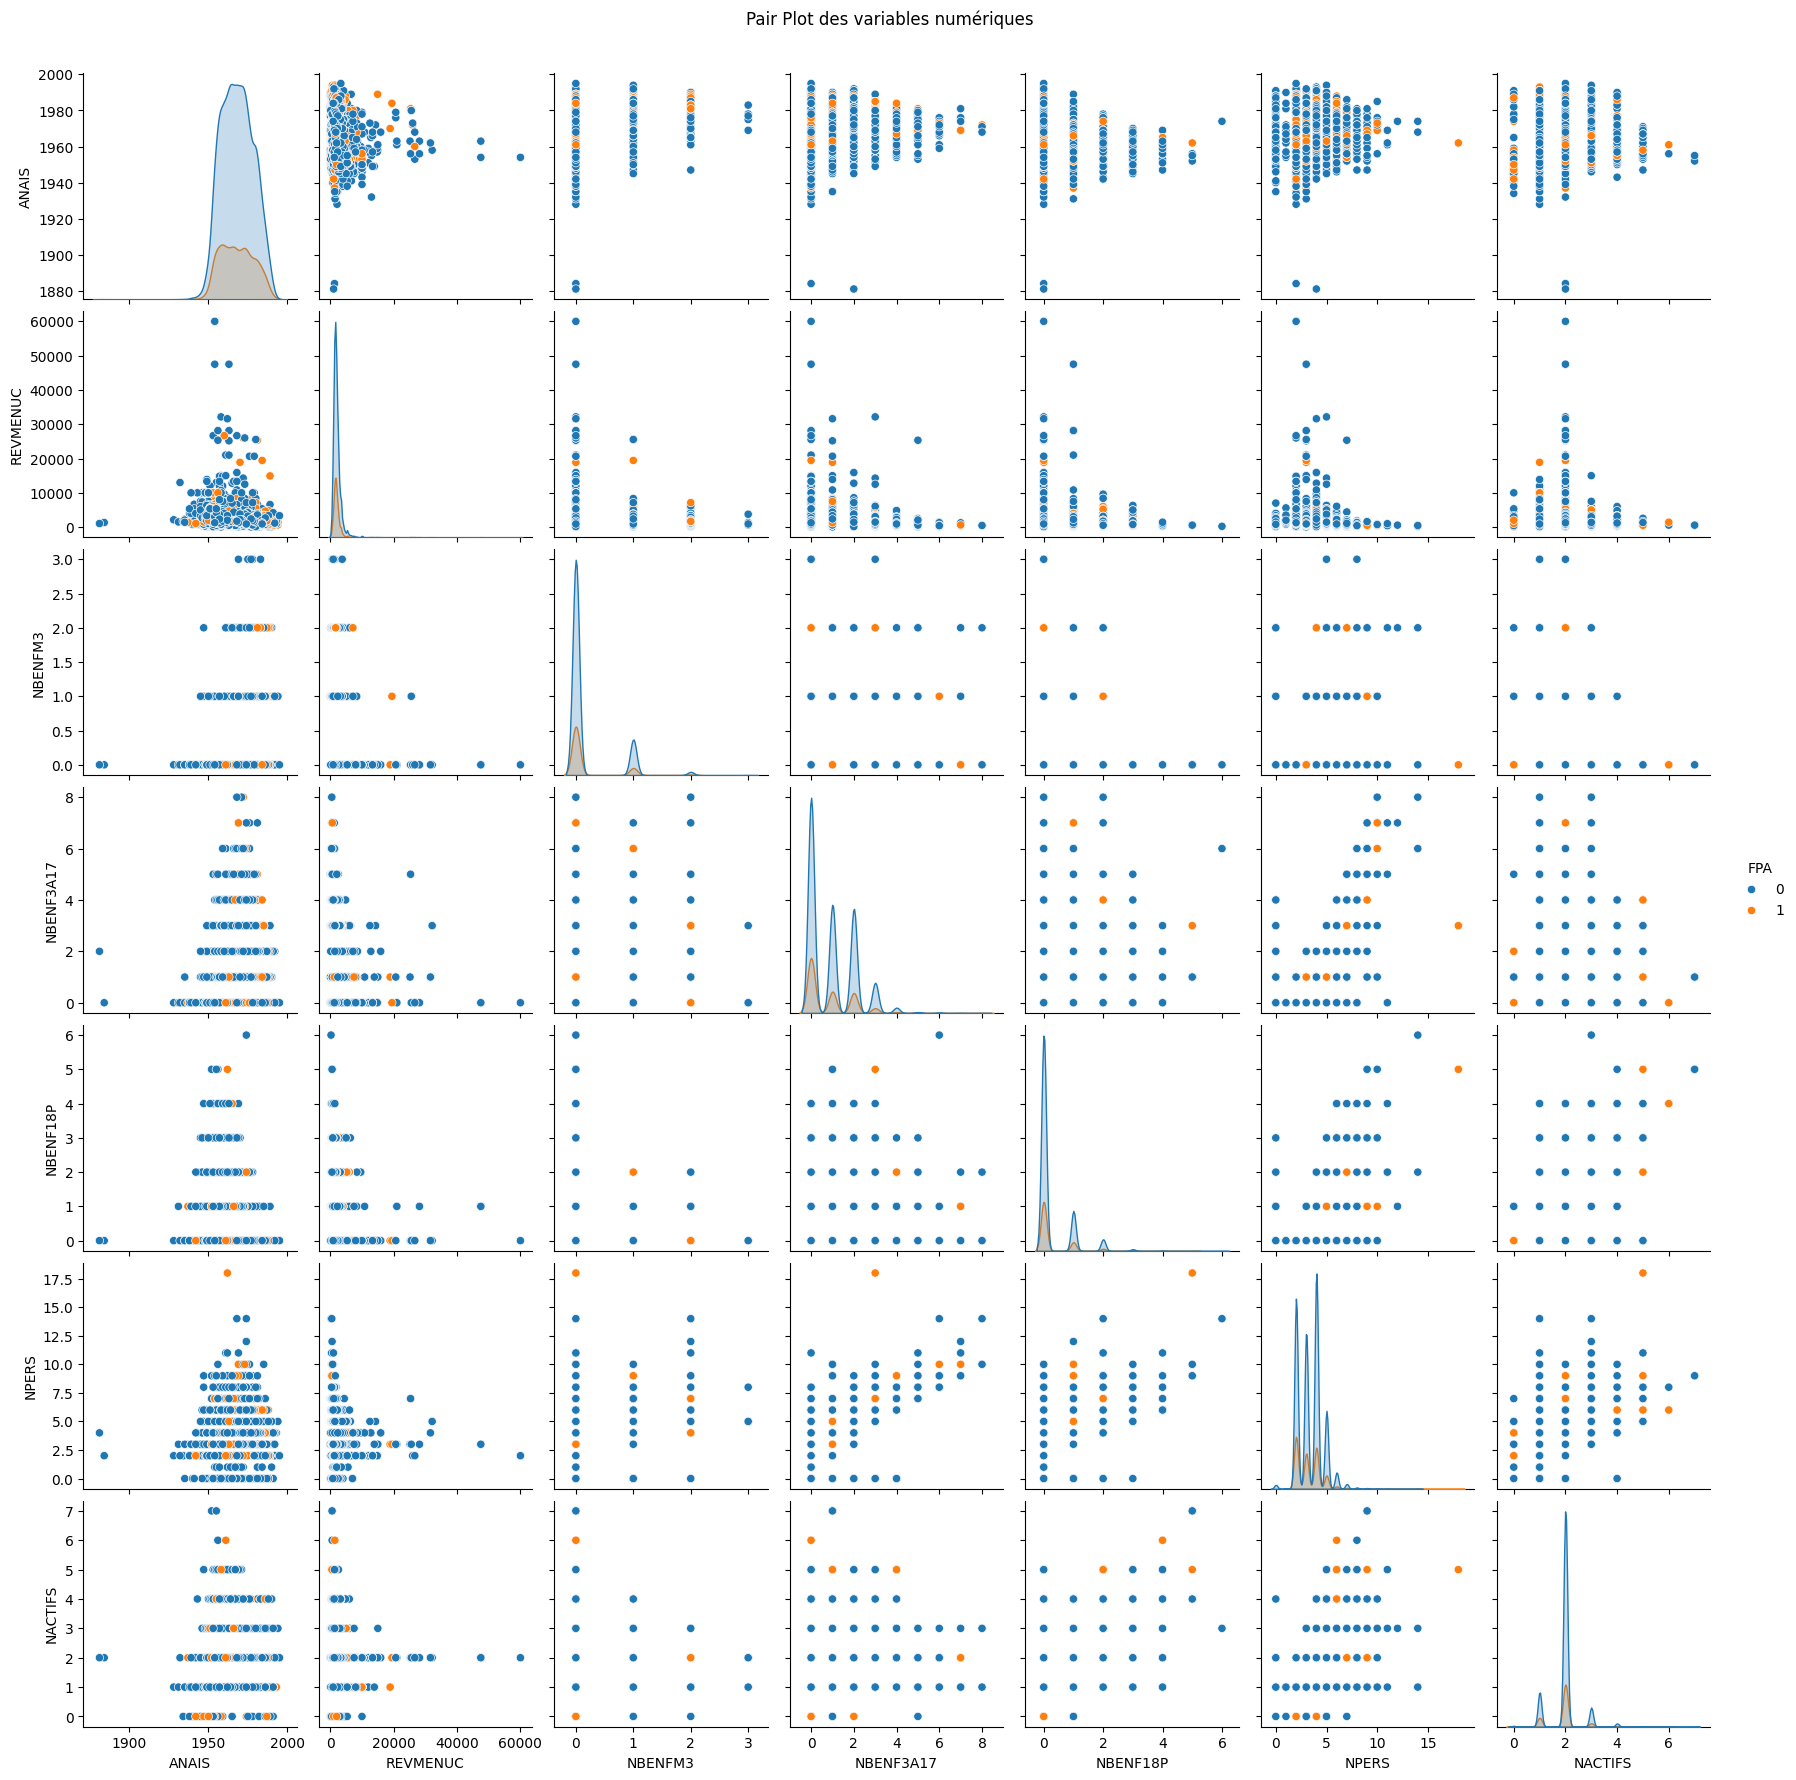

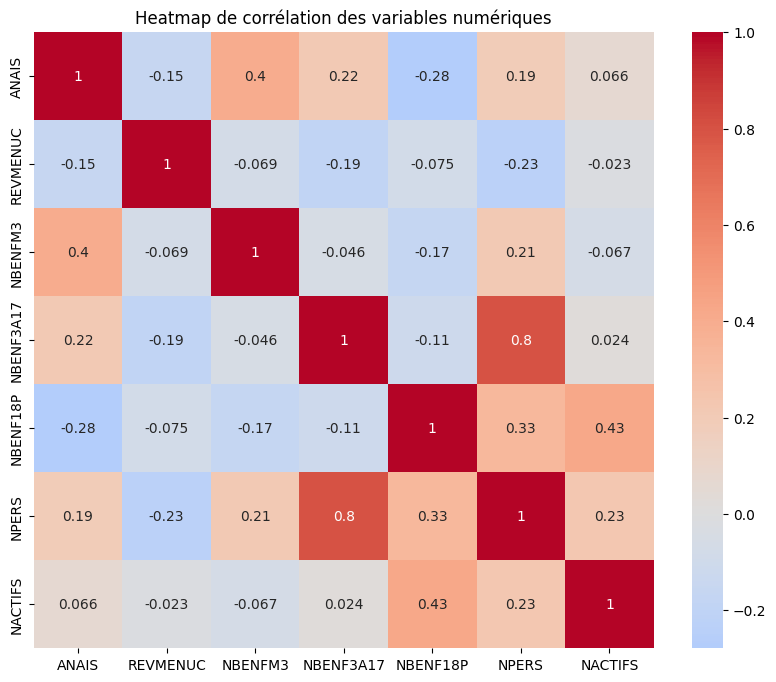

Exploration des variables de la catégorie : target


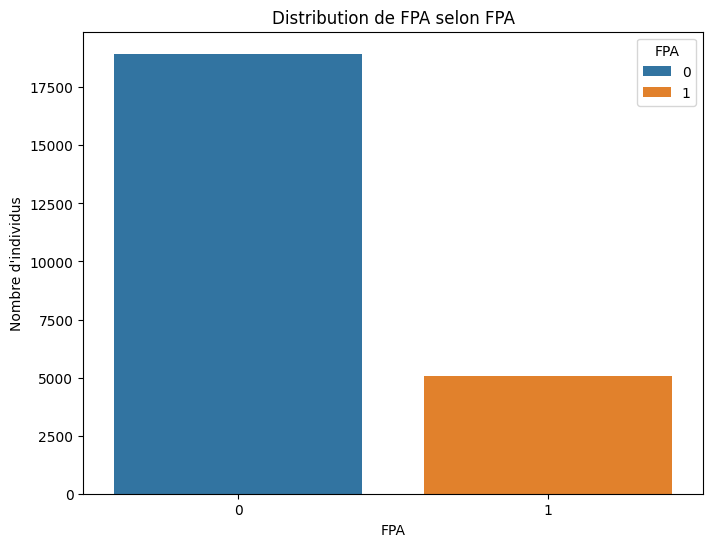




Exploration des variables de la catégorie : etat_civil_familial


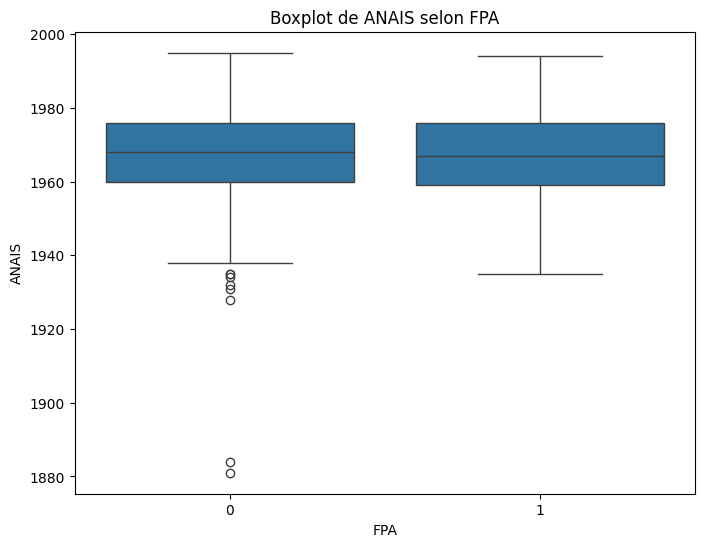

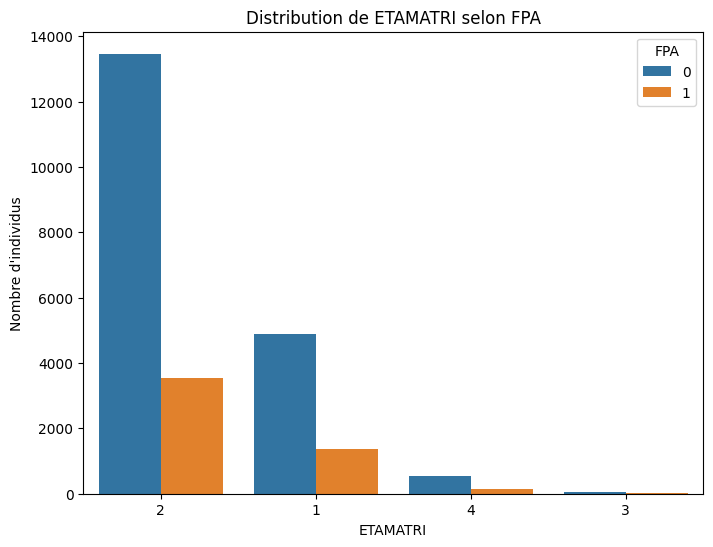

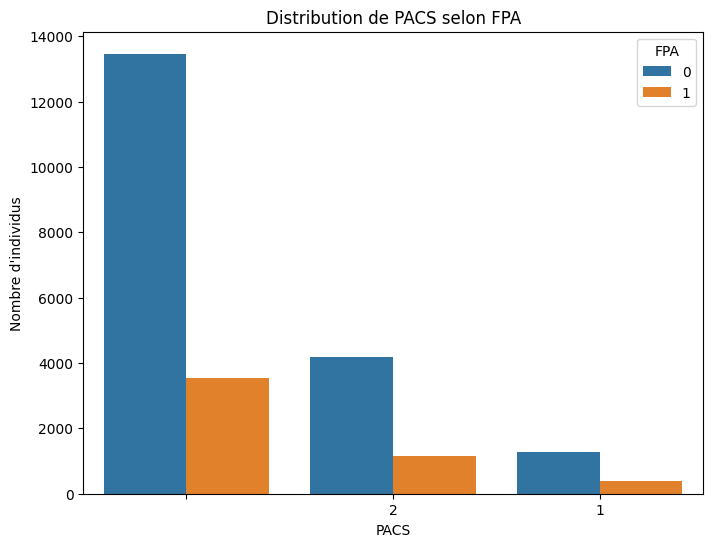

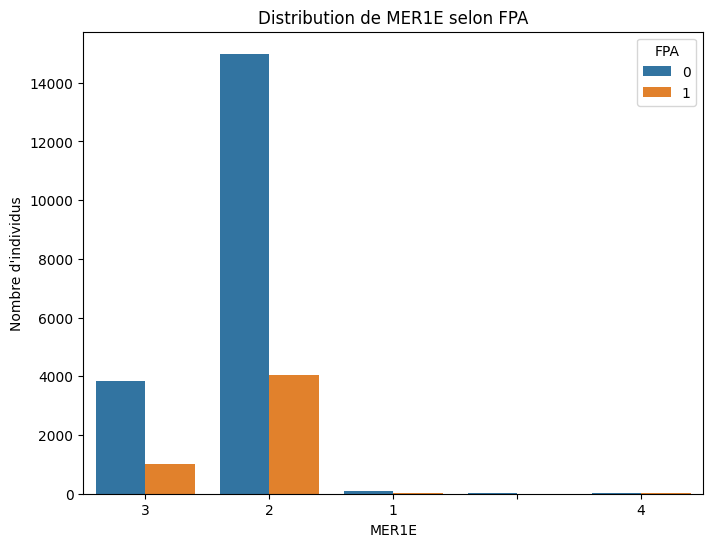

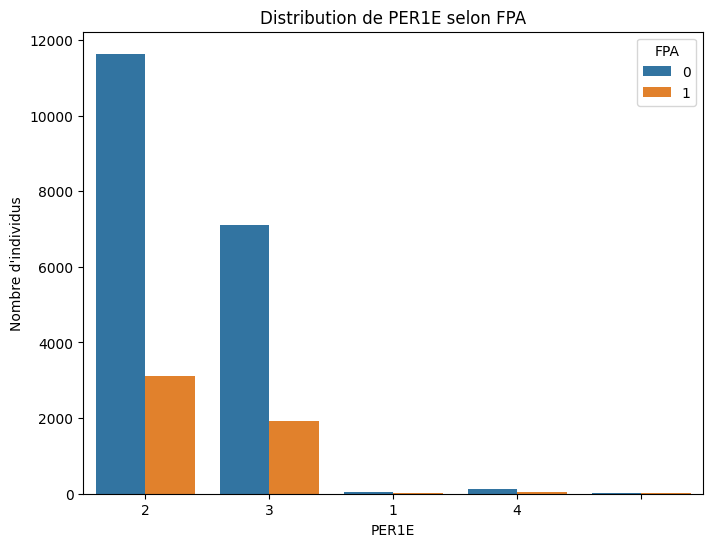




Exploration des variables de la catégorie : situation_travail


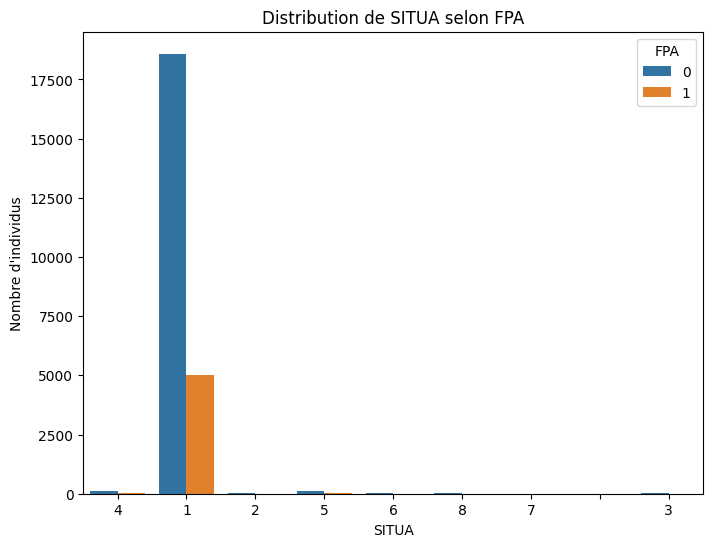

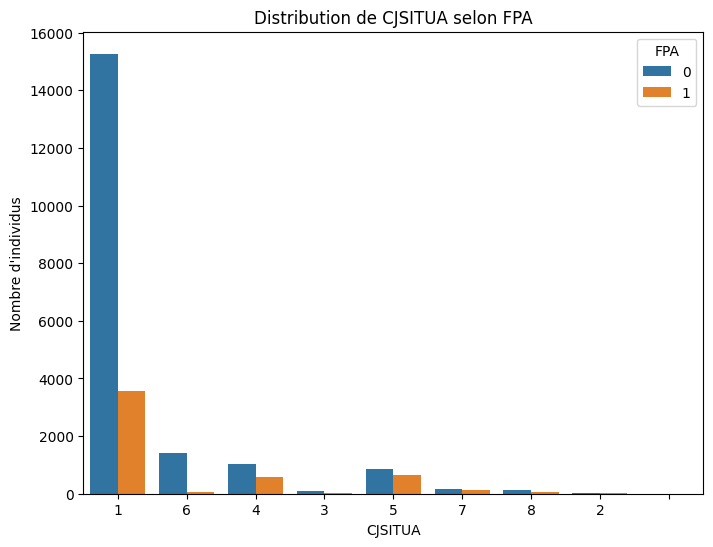

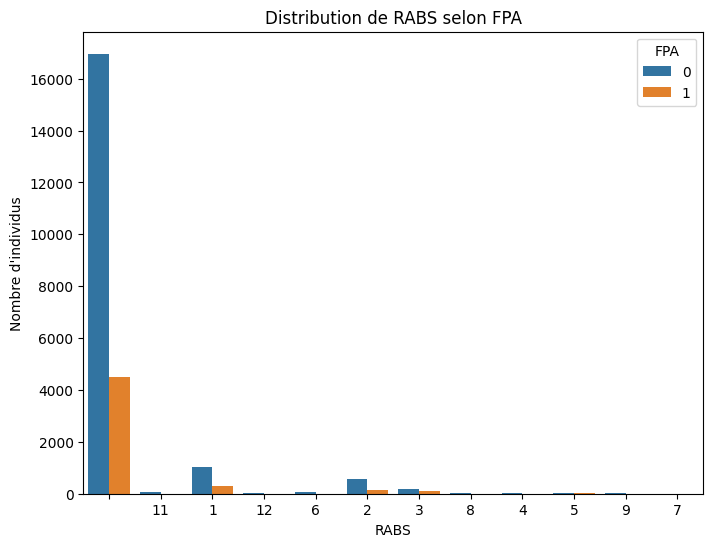

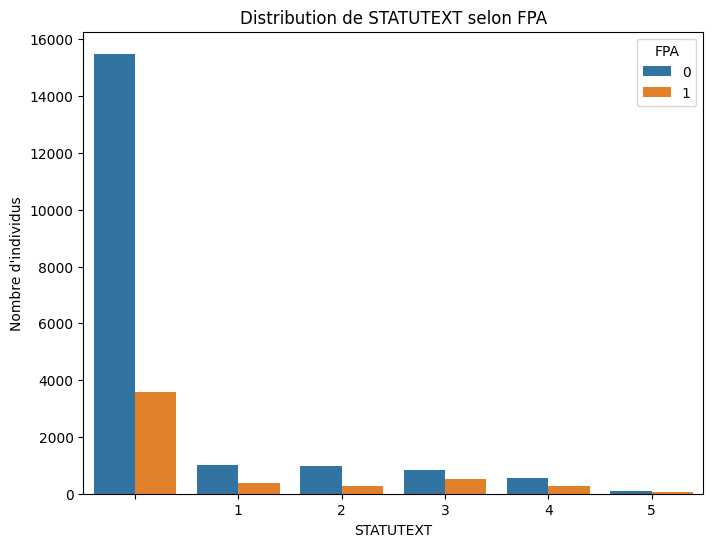

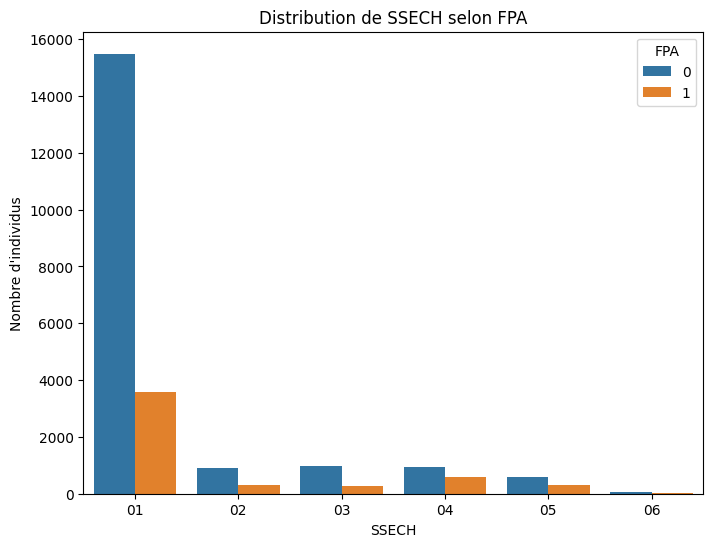

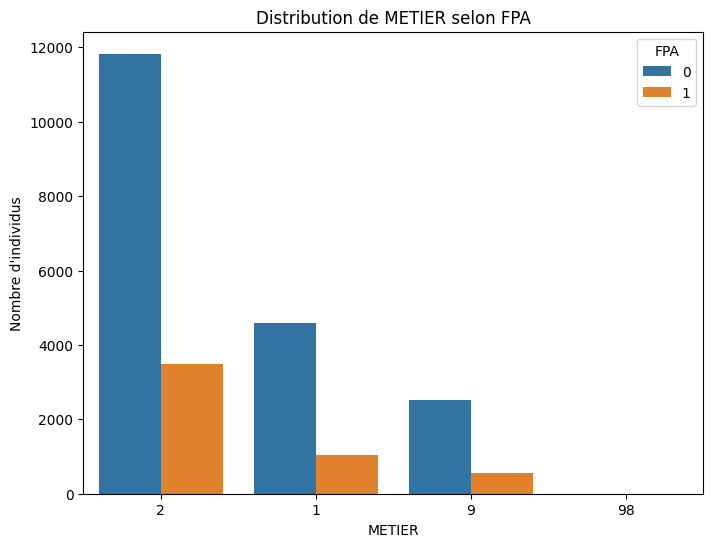




Exploration des variables de la catégorie : revenus_conditions_vie


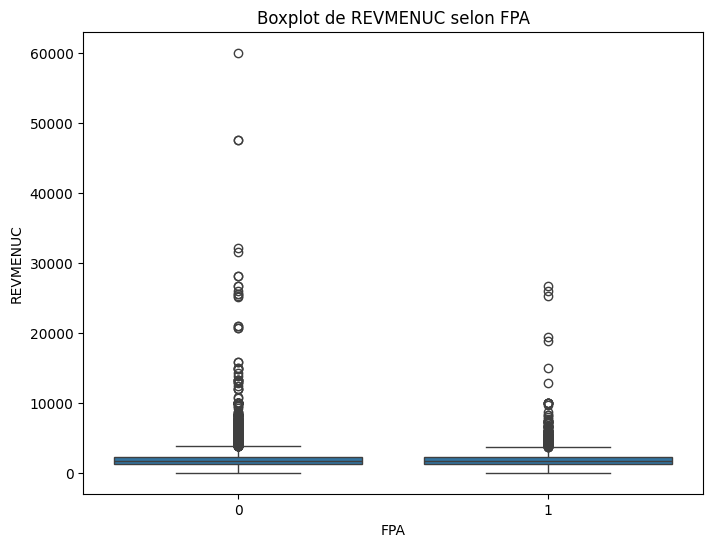

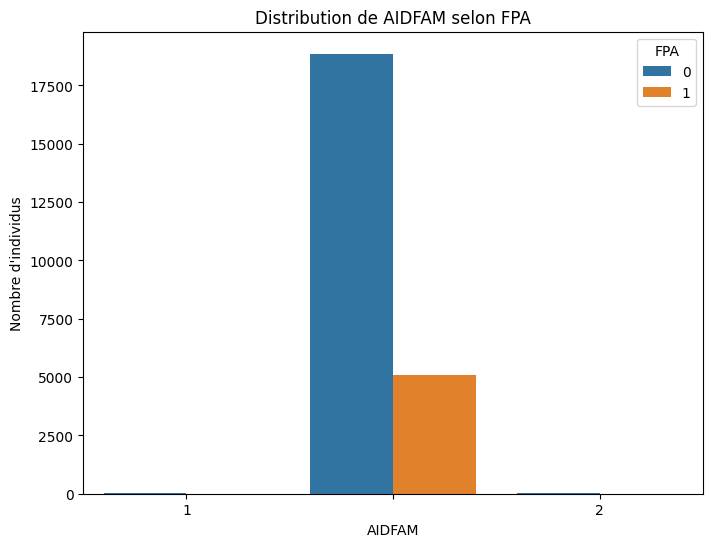




Exploration des variables de la catégorie : caracteristiques_logement_familial


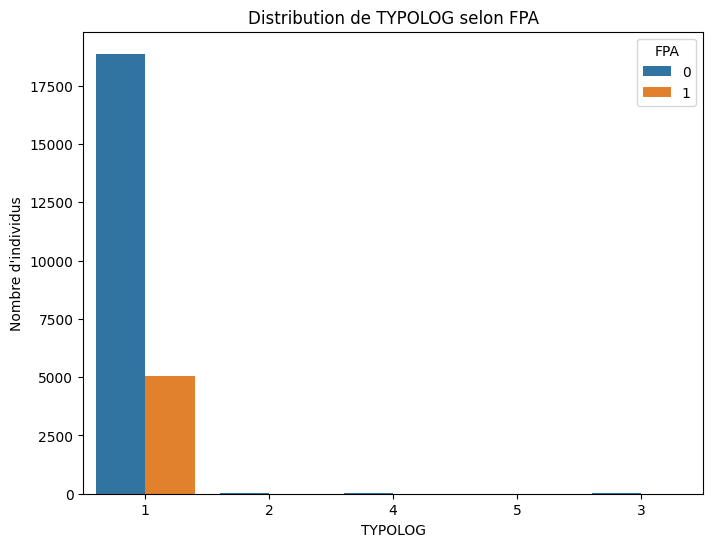

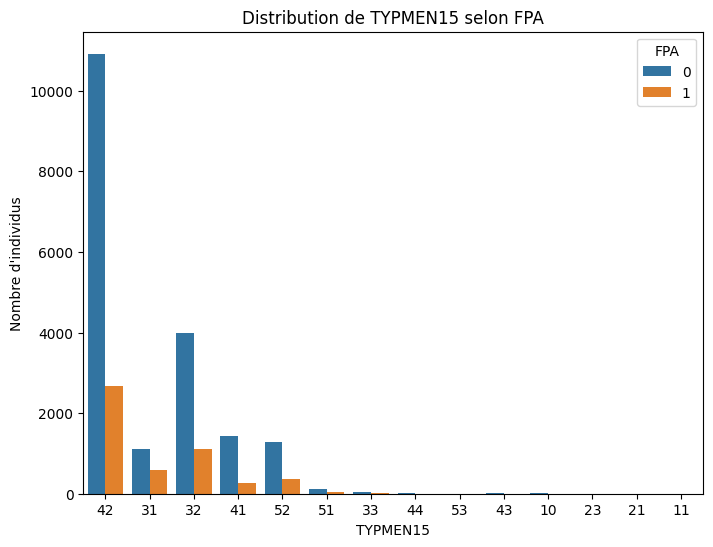

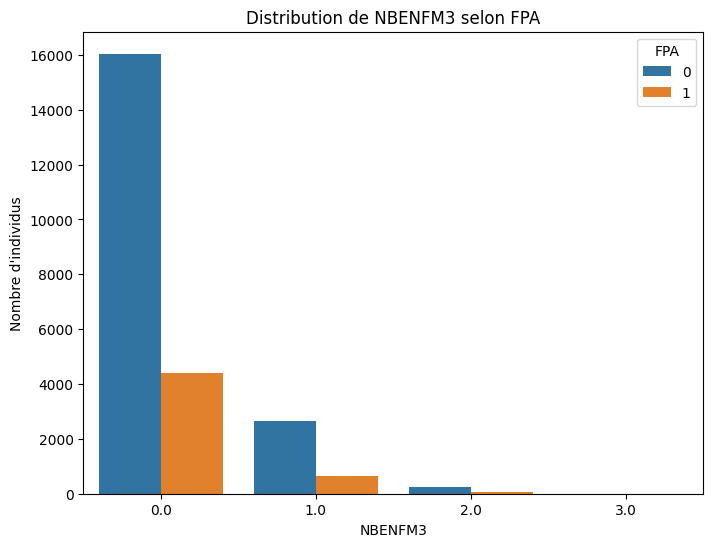

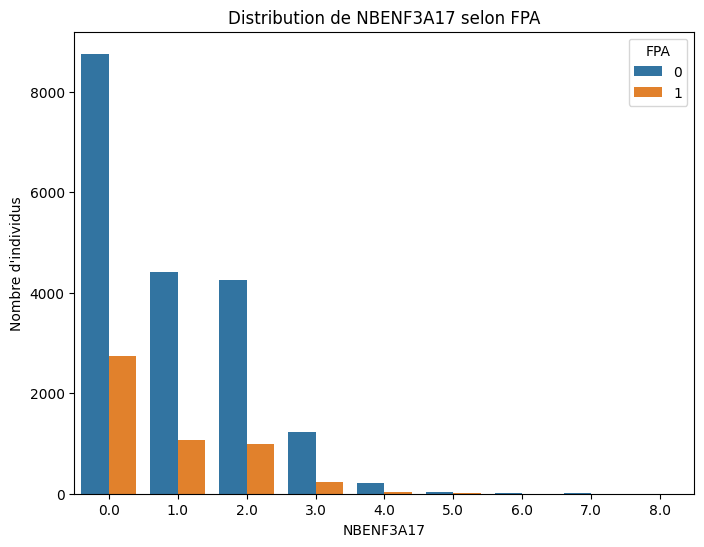

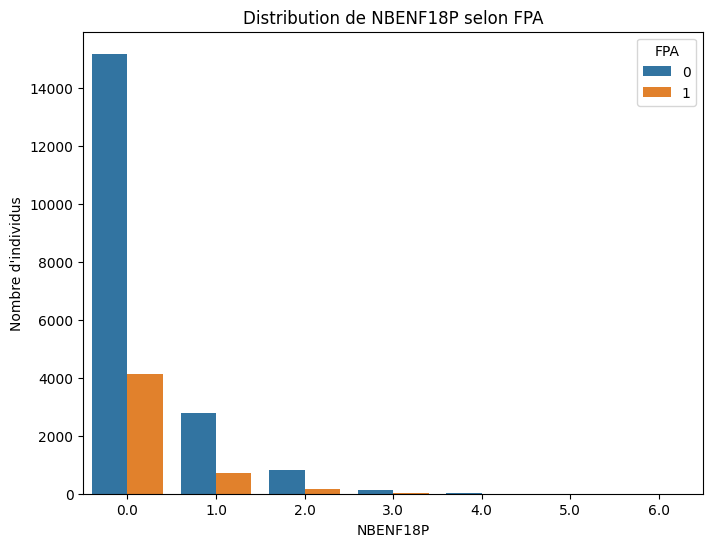

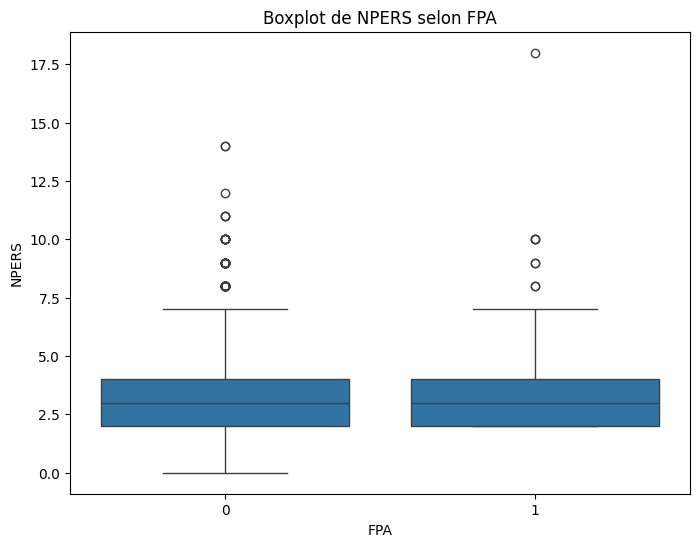

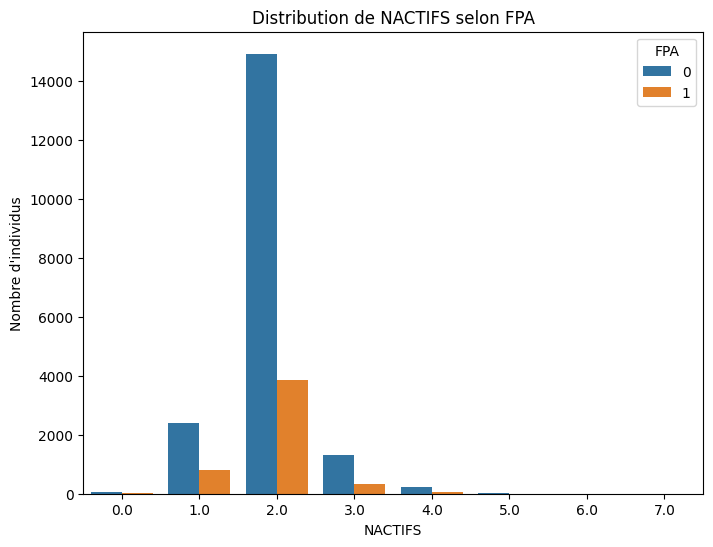

In [16]:
def explore_data(df, variables_dict, target_variable='FPA'):

    # Pair plot pour les variables numériques
    numeric_vars = [var for sublist in variables_dict.values() for var in sublist if df[var].dtype != 'object' and var != target_variable]
    if numeric_vars:
        sns.pairplot(df, vars=numeric_vars, hue=target_variable, diag_kind='kde')
        plt.suptitle("Pair Plot des variables numériques", y=1.02)
        plt.show()
    
    # Heatmap de corrélation pour les variables numériques
    if numeric_vars:
        plt.figure(figsize=(10, 8))
        corr_matrix = df[numeric_vars].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title("Heatmap de corrélation des variables numériques")
        plt.show()
    
    # Count plot pour les variables catégorielles
    for category, variable_list in variables_dict.items():
        print(f"Exploration des variables de la catégorie : {category}")
        for var in variable_list:
            if df[var].dtype == 'object' or df[var].nunique() < 10:
                plt.figure(figsize=(8, 6))
                sns.countplot(x=var, hue=target_variable, data=df)
                plt.title(f"Distribution de {var} selon {target_variable}")
                plt.xlabel(var)
                plt.ylabel("Nombre d'individus")
                plt.legend(title=target_variable, loc='upper right')
                plt.show()
                print("\n\n")
            else:
                # Box plot pour les variables numériques
                plt.figure(figsize=(8, 6))
                sns.boxplot(x=target_variable, y=var, data=df)
                plt.title(f"Boxplot de {var} selon {target_variable}")
                plt.xlabel(target_variable)
                plt.ylabel(var)
                plt.show()
                print("\n\n")

explicatives = [var for sublist in variables_dict.values() for var in sublist] #Filtrage du df sur les 25 variables sélectionnées 'manuellement'
df_filtered = df[explicatives].copy()

explore_data(df_filtered, variables_dict)

## Modélisation
* Régression logistique pour modéliser la probabilité qu'une femme soit le principal apporteur de ressources du ménage. 
* Evaluation et diagnostique du modele
* Interprétation des résultats

In [15]:
# Préparation des données pour la régression logistique
X = df[explicatives]
y = df['FPA']

# Ajout d'une constante pour l'interception
X = sm.add_constant(X)

# Régression logistique avec statsmodels
model = sm.Logit(y, X)
result = model.fit()

# Résumé du modèle
print(result.summary())

# Préparation des données pour sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Régression logistique avec sklearn
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Prédictions
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:,1]

# Évaluation du modèle
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('AUC: ', roc_auc_score(y_test, y_prob))

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).